In [1]:
from PIL import Image
import cPickle as pkl
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
%matplotlib inline  
print ("Packs loaed.")

Packs loaed.


# Load dataset for semantic segmentation

In [2]:
# Location of the files
camvidpath = 'data/seg/SegNet-Tutorial-master/CamVid/'
# Training data
path1 = os.getcwd() + '/' + camvidpath + 'train/'
path2 = os.getcwd() + '/' + camvidpath + 'trainannot/'
trainimglist = glob.glob(path1 + '/*.png')
trainannotlist = glob.glob(path2 + '/*.png')
print ("%d train images" % (len(trainimglist)))
print ("%d train annotations" % (len(trainannotlist)))

# Test data
path1 = os.getcwd() + '/' + camvidpath + 'test/'
path2 = os.getcwd() + '/' + camvidpath + 'testannot/'
testimglist = glob.glob(path1 + '/*.png')
testannotlist = glob.glob(path2 + '/*.png')
print ("%d test images" % (len(testimglist)))
print ("%d test annotations" % (len(testannotlist)))

367 train images
367 train annotations
233 test images
233 test annotations


# Get train / test images

In [3]:
height = 128
width = 128
nrclass = 22
trainData = None
trainLabel = None
trainLabelOneHot = None
trainlen = len(trainimglist)
testData = None
testLabel = None
testLabelOneHot = None
testlen = len(testimglist)
def DenseToOneHot(labels_dense, num_classes):
    # Convert class labels from scalars to one-hot vectors. 
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot
""" Train data process """ 
for (f1, f2, i) in zip(trainimglist, trainannotlist, range(trainlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, trainlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((128, 128))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((width, height), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        trainData = rgb
        trainLabel = label
    else:
        trainData = np.concatenate((trainData, rgb), axis=0)
        trainLabel = np.concatenate((trainLabel, label), axis=0)
# Onehot-coded label
trainLabelOneHot = np.zeros((trainLabel.shape[0], trainLabel.shape[1], trainLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = trainLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        trainLabelOneHot[:, row, col, :] = oneHot
print ("Train data process done.")        
""" Test data process """ 
for (f1, f2, i) in zip(testimglist, testannotlist, range(testlen)):
    # print ("[%02d/%02d]f1: %sf2: %s" % (i, testlen, f1, f2))
    # Train image
    img1 = Image.open(f1)
    img1 = img1.resize((128, 128))
    rgb  = np.array(img1).reshape(1, height, width, 3)
    # Train label
    img2 = Image.open(f2)
    img2 = img2.resize((width, height), Image.NEAREST)
    label = np.array(img2).reshape(1, height, width, 1)
    # Stack images and labels
    if i == 0: 
        testData = rgb
        testLabel = label
    else:
        testData = np.concatenate((testData, rgb), axis=0)
        testLabel = np.concatenate((testLabel, label), axis=0)
# Onehot-coded label
testLabelOneHot = np.zeros((testLabel.shape[0], testLabel.shape[1], testLabel.shape[2], nrclass))
for row in range(height):
    for col in range(width):
        single = testLabel[:, row, col, 0]
        oneHot = DenseToOneHot(single, nrclass) # (367,) => (367, 22)
        testLabelOneHot[:, row, col, :] = oneHot
print ("Test data process done.")

Train data process done.
Test data process done.


In [4]:
print ("Shape of 'trainData' is %s" % (trainData.shape,))
print ("Shape of 'trainLabel' is %s" % (trainLabel.shape,))
print ("Shape of 'trainLabelOneHot' is %s" % (trainLabelOneHot.shape,))
print ("Shape of 'testData' is %s" % (testData.shape,))
print ("Shape of 'testLabel' is %s" % (testLabel.shape,))
print ("Shape of 'testLabelOneHot' is %s" % (testLabelOneHot.shape,))

Shape of 'trainData' is (367, 128, 128, 3)
Shape of 'trainLabel' is (367, 128, 128, 1)
Shape of 'trainLabelOneHot' is (367, 128, 128, 22)
Shape of 'testData' is (233, 128, 128, 3)
Shape of 'testLabel' is (233, 128, 128, 1)
Shape of 'testLabelOneHot' is (233, 128, 128, 22)


# Define networks

In [5]:
# Define functions
x = tf.placeholder(tf.float32, [None, height, width, 3])
y = tf.placeholder(tf.float32, [None, height, width, nrclass])
keepprob = tf.placeholder(tf.float32)
# Kernels
ksize = 7
fsize = 64
weights = {
    'ce1': tf.get_variable("ce1", shape = [ksize, ksize, 3, fsize]),
    'ce2': tf.get_variable("ce2", shape = [ksize, ksize, fsize, fsize]),
    'ce3': tf.get_variable("ce3", shape = [ksize, ksize, fsize, fsize]),
    'ce4': tf.get_variable("ce4", shape = [ksize, ksize, fsize, fsize]),
    'cd4': tf.get_variable("cd4", shape = [ksize, ksize, fsize, fsize]),
    'cd3': tf.get_variable("cd3", shape = [ksize, ksize, fsize, fsize]),
    'cd2': tf.get_variable("cd2", shape = [ksize, ksize, fsize, fsize]),
    'cd1': tf.get_variable("cd1", shape = [ksize, ksize, fsize, fsize]),
    'dense_inner_prod': tf.get_variable("dense_inner_prod", shape= [1, 1, fsize, nrclass])
}

In [6]:
# input : [m, h, w, c]
def Unpooling(inputOrg, size, mask=None):
    # m, c, h, w order
    m = size[0]
    h = size[1]
    w = size[2]
    c = size[3]
    input = tf.transpose(inputOrg, [0, 3, 1, 2])
    x = tf.reshape(input, [-1, 1])
    k = np.float32(np.array([1.0, 1.0]).reshape([1,-1]))
    output = tf.matmul(x, k)
    output = tf.reshape(output,[-1, c, h, w * 2])
    # m, c, w, h
    xx = tf.transpose(output, [0, 1, 3, 2])
    xx = tf.reshape(xx,[-1, 1])
    output = tf.matmul(xx, k)
    # m, c, w, h
    output = tf.reshape(output, [-1, c, w * 2, h * 2])
    output = tf.transpose(output, [0, 3, 2, 1])
    outshape = tf.pack([m, h * 2, w * 2, c])
    if mask != None:
        dense_mask = tf.sparse_to_dense(mask, outshape, output, 0)
        return output, dense_mask
    else:
        return output

# DeconvNet Model
def Model(_X, _W, _keepprob):
    # Encoder 128x128
    encoder1 = tf.nn.conv2d(_X, _W['ce1'], strides=[1, 1, 1, 1], padding='SAME')
    encoder1 = tf.nn.batch_normalization(encoder1,0.001,1.0,0,1,0.0001)
    encoder1 = tf.nn.relu(encoder1)
    encoder1 = tf.nn.max_pool(encoder1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder1 = tf.nn.dropout(encoder1, _keepprob)
    # 64x64
    encoder2 = tf.nn.conv2d(encoder1, _W['ce2'], strides=[1, 1, 1, 1], padding='SAME')
    encoder2 = tf.nn.batch_normalization(encoder2, 0.001, 1.0, 0, 1, 0.0001)
    encoder2 = tf.nn.relu(encoder2)
    encoder2 = tf.nn.max_pool(encoder2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder2 = tf.nn.dropout(encoder2, _keepprob)
    # 32x32
    encoder3 = tf.nn.conv2d(encoder2, _W['ce3'], strides=[1, 1, 1, 1], padding='SAME')
    encoder3 = tf.nn.batch_normalization(encoder3, 0.001, 1.0, 0, 1, 0.0001)
    encoder3 = tf.nn.relu(encoder3)
    encoder3 = tf.nn.max_pool(encoder3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder3 = tf.nn.dropout(encoder3, _keepprob)
    # 16x16
    encoder4 = tf.nn.conv2d(encoder3, _W['ce4'], strides=[1, 1, 1, 1], padding='SAME')
    encoder4 = tf.nn.batch_normalization(encoder4, 0.001, 1.0, 0, 1, 0.0001)
    encoder4 = tf.nn.relu(encoder4)
    encoder4 = tf.nn.max_pool(encoder4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    encoder4 = tf.nn.dropout(encoder4, _keepprob)
    # 8x8

    # Decoder 8x8
    decoder4 = Unpooling(encoder4, [tf.shape(_X)[0], height / 16, width / 16, fsize])
    decoder4 = tf.nn.conv2d(decoder4, _W['cd4'], strides=[1, 1, 1, 1], padding='SAME')
    decoder4 = tf.nn.batch_normalization(decoder4, 0.001, 1.0, 0, 1, 0.0001)
    decoder4 = tf.nn.relu(decoder4)
    decoder4 = tf.nn.dropout(decoder4, _keepprob)
    # 16x16
    decoder3 = Unpooling(encoder3, [tf.shape(_X)[0], height/8, width/8, fsize])
    decoder3 = tf.nn.conv2d(decoder3, _W['cd3'], strides=[1, 1, 1, 1], padding='SAME')
    decoder3 = tf.nn.batch_normalization(decoder3, 0.001, 1.0, 0, 1, 0.0001)
    decoder3 = tf.nn.relu(decoder3)
    decoder3 = tf.nn.dropout(decoder3, _keepprob)
    # 32x32
    decoder2 = Unpooling(decoder3, [tf.shape(_X)[0], height/4, width/4, fsize])
    decoder2 = tf.nn.conv2d(decoder2, _W['cd2'], strides=[1, 1, 1, 1], padding='SAME')
    decoder2 = tf.nn.batch_normalization(decoder2, 0.001, 1.0, 0, 1, 0.0001)
    decoder2 = tf.nn.relu(decoder2)
    decoder2 = tf.nn.dropout(decoder2, _keepprob)
    # 64x64
    decoder1 = Unpooling(decoder2, [tf.shape(_X)[0], height / 2, width / 2, fsize])
    decoder1 = tf.nn.conv2d(decoder1, _W['cd1'], strides=[1, 1, 1, 1], padding='SAME')
    decoder1 = tf.nn.batch_normalization(decoder1, 0.001, 1.0, 0, 1.0, 0.0001)
    decoder1 = tf.nn.relu(decoder1)
    decoder1 = tf.nn.dropout(decoder1, _keepprob)
    # 128x128
    output = tf.nn.conv2d(decoder1, _W['dense_inner_prod'], strides=[1, 1, 1, 1], padding='SAME')
    return output

print ("Network ready")

Network ready


# Our main body 

In [ ]:
pred = Model(x, weights, keepprob)
lin_pred = tf.reshape(pred, shape=[-1, nrclass])
lin_y = tf.reshape(y, shape=[-1, nrclass])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(lin_pred, lin_y))
# Class label
predmax = tf.argmax(pred, 3)
ymax = tf.argmax(y, 3)
# Accuracy
corr = tf.equal(tf.argmax(y,3), tf.argmax(pred, 3)) 
accr = tf.reduce_mean(tf.cast(corr, "float"))
# Optimizer
optm = tf.train.AdamOptimizer(0.0001).minimize(cost)
batch_size = 50
n_epochs = 10000

# Real optimization starts here

checkpoint: nets/deconv_again/progress-0
Restoring from checkpoint nets/deconv_again/progress-0
[0/10000] valLoss: 0.9 valAcc: 0.74


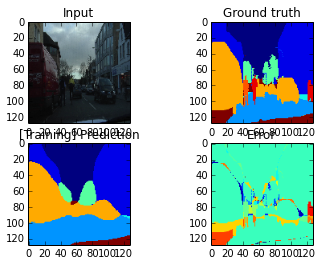

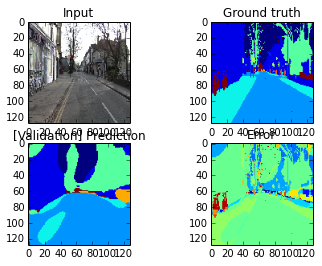

In [ ]:
resumeTraining = True
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    checkpoint = tf.train.latest_checkpoint("nets/deconv_again")
    print ("checkpoint: %s" % (checkpoint))
    if resumeTraining == False:
        print "Start from scratch"
    elif  checkpoint:
        print "Restoring from checkpoint", checkpoint
        saver.restore(sess, checkpoint)
    else:
        print "Couldn't find checkpoint to restore from. Starting over."
    
    for epoch_i in range(n_epochs):
        trainLoss = []
        trainAcc = []
        for start, end in zip(range(0, len(trainData), batch_size), range(batch_size, len(trainData), batch_size)):
            batchData = trainData[start:end]
            batchLabel = trainLabelOneHot[start:end]
            sess.run(optm, feed_dict={x: batchData, y: batchLabel, keepprob: 0.5})
            trainLoss.append(sess.run(cost, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
            trainAcc.append(sess.run(accr, feed_dict={x: batchData, y: batchLabel, keepprob: 1.}))
        # Average loss and accuracy
        trainLoss = np.mean(trainLoss)
        trainAcc = np.mean(trainAcc)
        # Run test
        valLoss = sess.run(cost, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        valAcc = sess.run(accr, feed_dict={x: testData, y: testLabelOneHot, keepprob: 1.})
        
        # Save snapshot
        if resumeTraining and epoch_i % 50 == 0:
            print ("[%d/%d] valLoss: %.1f valAcc: %.2f" % (epoch_i, n_epochs, valLoss, valAcc))
            saver.save(sess, 'nets/deconv_again/progress', global_step=epoch_i)
            # Train data
            index = np.random.randint(trainData.shape[0])
            batchData = trainData[index:index+1]
            batchLabel = trainLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            # Plot
            plt.figure(0)
            plt.subplot(2, 2, 1)
            plt.title('Input')
            img = trainData[index, :, :, :].reshape(height, width, 3)
            plt.imshow(img)
            plt.subplot(2, 2, 2)
            plt.title('Ground truth')
            img = yMaxOut[0, :, :].reshape(height, width)
            plt.imshow(img)
            plt.subplot(2, 2, 3)
            plt.title('[Training] Prediction')
            plt.imshow(predMaxOut[0, :, :].reshape(height, width))
            plt.subplot(2, 2, 4)
            plt.title('Error')
            plt.imshow(img - predMaxOut[0, :, :].reshape(height, width))
            plt.show()
            # Test data
            index = np.random.randint(testData.shape[0])
            batchData = testData[index:index+1]
            batchLabel = testLabelOneHot[index:index+1]
            predMaxOut = sess.run(predmax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            yMaxOut = sess.run(ymax, feed_dict={x: batchData, y: batchLabel, keepprob:1.})
            # Plot
            plt.figure(1)
            plt.subplot(2, 2, 1)
            plt.title('Input')
            img = testData[index, :, :, :].reshape(height, width, 3)
            plt.imshow(img)
            plt.subplot(2, 2, 2)
            plt.title('Ground truth')
            img = yMaxOut[0, :, :].reshape(height, width)
            plt.imshow(img)
            plt.subplot(2, 2, 3)
            plt.title('[Validation] Prediction')
            plt.imshow(predMaxOut[0, :, :].reshape(height, width))
            plt.subplot(2, 2, 4)
            plt.title('Error')
            plt.imshow(img - predMaxOut[0, :, :].reshape(height, width))
            plt.show()

print ("Done")